<center><img src="https://drive.google.com/uc?export=view&id=1ygAs8EMNlIim2ypwmvQn9yN1LbY3hWHV" alt="Drawing"  width="30%"/><center>

# <center><strong>Development notebook</strong></center>
<br/>

<br/><center>This notebook allows you to visualize the data used in the **FLAIR #2 challenge**.<br/>The code bellow works with the toy dataset (subset) provided in the starting-kit alongside this notebook as well as with the full FLAIR-two dataset accessible after registration to the competition.</center> <br/> 
<center>**We also strongly advise you to read the data technical description provided in the datapaper.**</center>
<br/> <br/> 
  


Handle all the generic imports

In [1]:
import yaml
import sys
import torch

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from sklearn.cluster import HDBSCAN
from os.path import join
from pathlib import Path
from importlib import reload

Import code from or based upon the FLAIR-2 reference implementation 

In [2]:
FLAIR_path = join(Path.cwd().parents[0],'FLAIR-code/src')
if FLAIR_path not in sys.path:
    sys.path.append(FLAIR_path)

from data_display import (display_nomenclature,
                            display_samples, 
                            display_time_serie,
                            display_all_with_semantic_class, 
                            display_all, 
                            read_dates, 
                            filter_dates)
from load_data import load_data
from FusedDataset import FusedDataset
from calc_miou import calc_miou


## <font color='#90c149'>Load Data</font>

<br/><hr>

Use reference code to create lists containing the paths to the input images (`images`) and supervision masks (`masks`) files of the dataset.<hr><br/>

In [3]:
config_path = "/app/FLAIR-HDBSCAN/flair-2-config.yml" 
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Creation of the train, val, and test dictionaries with the data file paths
# Note that due to using the toy dataset we assign 100% of the data for training. 
# While not best practice for machine learning, for the toy dataset when using the stock code and less than 100%, issues randomly arise when using the reference loader
# as the random selection can result in some semantic classes not being represented. If the full FLAIR #2 dataset were employed, validation data should be separate. 
# Due to size limitations on HDBSCAN, for actual training we downsample to ~1 % of the training data for training and use 100% of the training data for fitting. 
d_train, d_val, d_test = load_data(config, val_percent=1)

# Convert to torch Datasets
train_dataset = FusedDataset(dict_files=d_train, config=config)
valid_dataset = FusedDataset(dict_files=d_val, config=config)
test_dataset = FusedDataset(dict_files=d_val, config=config)

<br><br>
<hr style="height:3px;border-width:0;color:red;background-color:red">   

# <center><font color='red'>PART-2: Development area</font></center>

<br/><hr>

Area under active development. 

<hr><br/>

In [4]:
project_path = join(Path.cwd().parents[0],'code')
if project_path not in sys.path:
    sys.path.append(project_path)

In [13]:
import display
reload(display)
from display import box_whisker_by_class
from display import display_confusion
from display import display_normalization_scatter

import classifier
reload(classifier)
from classifier import extract_aerial_spectra
from classifier import train_and_validate_model

In [14]:
%%time
hdbscan_model_and_predictions = train_and_validate_model(train_dataset, config, use_hdbscan=True)

<class 'numpy.ndarray'>
int64
Originally processing 94874 pixels.
HDBSCAN found 380 clusters.
Clusters were assigned to semantic classes with a mean reliability of 0.9086111324029708, 
 and a weighted mean reliability of 0.9362579993263725
CPU times: user 16min 19s, sys: 9.3 s, total: 16min 28s
Wall time: 11min 48s


MIOU for HDBSCAN Validation cluster size 10 is: 0.4246128617004927


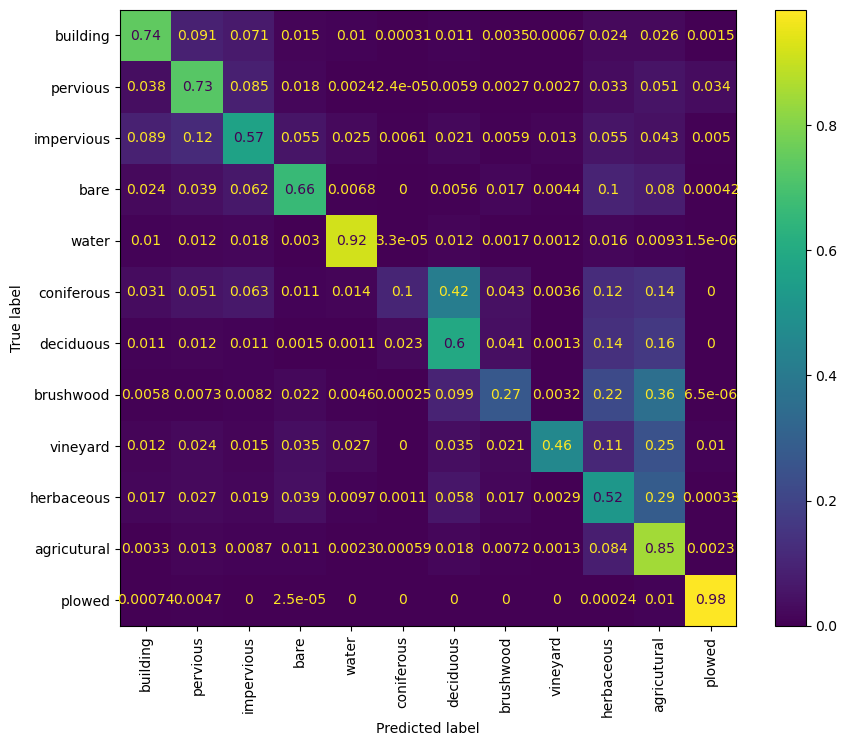

In [15]:
display_confusion(hdbscan_model_and_predictions['true_classes'], hdbscan_model_and_predictions['predicted_classes'], config, 'HDBSCAN Validation cluster size 10')

In [ ]:
import rasterio

def sentinel_pixels(aerial_images, sentinel_images, sentinel_masks, centroids, sentinel_products, idx):

    # Read in the aerial image. 
    with rasterio.open(aerial_images[idx], 'r') as f:
        im = f.read().swapaxes(0, 2).swapaxes(0, 1)

    # Determine the dates for all corresponding sentinel images
    sentinel_dates = read_dates(sentinel_products[idx])
    
    #Read in the corresponding sentinel images
    sen = np.load(sentinel_images[idx])[:,[2,1,0],:,:]/2000
    
    # Read in the corresponding cloud masks
    clouds = np.load(sentinel_masks[idx])

    dates_to_keep = filter_dates(sen, clouds)
    print(len(dates_to_keep))
    

    

    
    sen_spatch = sen[:, centroids[idx][0]-int(20):centroids[idx][0]+int(20),centroids[idx][1]-int(20):centroids[idx][1]+int(20)]
    print(centroids[idx])

    return im

    

In [ ]:
for idx in range(0,38):
    im = sentinel_pixels(train_aerial_images, train_sentinel_images, train_sentinel_masks, train_centroids, train_sentinel_products, idx)

In [ ]:
im = sentinel_pixels(train_aerial_images, train_sentinel_images, train_sentinel_masks, train_centroids, train_sentinel_products, 0)

In [ ]:
67-20

In [ ]:
plt.imshow(im[:, :, :3])

In [ ]:
clouds.shape

In [ ]:
sen.shape

In [ ]:
idx = 1

In [ ]:
plt.imshow(np.transpose(np.squeeze(sen[idx,:,:,:]), (1,2,0)))

In [ ]:
plt.imshow(np.squeeze(clouds[idx,1,:,:]))

In [ ]:
# Normalize the spectra?

In [ ]:
from matplotlib.colors import hex2color
from matplotlib.patches import Rectangle
import random
import torch
import torchvision.transforms as T

In [ ]:
lut_colors = {
1   : '#db0e9a',
2   : '#938e7b',
3   : '#f80c00',
4   : '#a97101',
5   : '#1553ae',
6   : '#194a26',
7   : '#46e483',
8   : '#f3a60d',
9   : '#660082',
10  : '#55ff00',
11  : '#fff30d',
12  : '#e4df7c',
13  : '#3de6eb',
14  : '#ffffff',
15  : '#8ab3a0',
16  : '#6b714f',
17  : '#c5dc42',
18  : '#9999ff',
19  : '#000000'}

In [ ]:
def convert_to_color(arr_2d: np.ndarray, palette: dict = lut_colors) -> np.ndarray:
    rgb_palette = {k: tuple(int(i * 255) for i in hex2color(v)) for k, v in palette.items()}
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)
    for c, i in rgb_palette.items():
        m = arr_2d == c
        arr_3d[m] = i
    return arr_3d


In [ ]:
def display_sample(images, masks, sentinel_imgs, centroid, palette=lut_colors, idx=0) -> None:
    print(idx)
    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 6)); fig.subplots_adjust(wspace=0.0, hspace=0.15)
    fig.patch.set_facecolor('black')

    with rasterio.open(images[idx], 'r') as f:
        im = f.read([1,2,3]).swapaxes(0, 2).swapaxes(0, 1)
    with rasterio.open(masks[idx], 'r') as f:
        mk = f.read([1])
        mk = convert_to_color(mk[0], palette=palette)
    
    sen = np.load(sentinel_imgs[idx])[20,[2,1,0],:,:]/2000
    offset = (0, 0)
    sen_spatch = sen[:, centroid[idx][0]-int(20) + offset[0]:centroid[idx][0]+int(20) + offset[0],
        centroid[idx][1]-int(20) + offset[1]:centroid[idx][1]+int(20) + offset[1]]
    transform = T.CenterCrop(10)
    sen_aerialpatch = transform(torch.as_tensor(np.expand_dims(sen_spatch, axis=0))).numpy()
    sen = np.transpose(sen, (1,2,0))
    sen_spatch = np.transpose(sen_spatch, (1,2,0))
    sen_aerialpatch = np.transpose(sen_aerialpatch[0], (1,2,0))

    #axs = axs if isinstance(axs[], np.ndarray) else [axs]
    ax0 = axs[0][0] ; ax0.imshow(im);ax0.axis('off')
    ax1 = axs[0][1] ; ax1.imshow(mk, interpolation='nearest') ;ax1.axis('off')
    ax2 = axs[0][2] ; ax2.imshow(im); ax2.imshow(mk, interpolation='nearest', alpha=0.25); ax2.axis('off')
    ax3 = axs[1][0] ; ax3.imshow(sen);ax3.axis('off')
    ax4 = axs[1][1] ; ax4.imshow(sen_spatch);ax4.axis('off')
    ax5 = axs[1][2] ; ax5.imshow(sen_aerialpatch);ax5.axis('off')

    # Create a Rectangle patch
    rect = Rectangle((centroid[idx][1]-5.12, centroid[idx][0]-5.12), 10.24, 10.24, linewidth=1, edgecolor='r', facecolor='none')
    ax3.add_patch(rect)
    rect = Rectangle((14.88, 14.88), 10.24, 10.24, linewidth=1, edgecolor='r', facecolor='none')
    ax4.add_patch(rect)
    
    ax0.set_title('RGB Image', size=12,fontweight="bold",c='w')
    ax1.set_title('Ground Truth Mask', size=12,fontweight="bold",c='w')
    ax2.set_title('Overlay Image & Mask', size=12,fontweight="bold",c='w')
    ax3.set_title('Sentinel super area', size=12,fontweight="bold",c='w')
    ax4.set_title('Sentinel super patch', size=12,fontweight="bold",c='w')
    ax5.set_title('Sentinel over the aerial patch', size=12,fontweight="bold",c='w')

In [ ]:
display_sample(train_aerial_images, train_labels, train_sentinel_images, train_centroids, idx=19)

In [ ]:
# Image 2
# Image 5
# Image 9 - clear half pixel shift
# Image 13

In [ ]:
np.arange(-100, 100)

#-int(20):int(20)